In [1]:
%load_ext autoreload
%autoreload 2

### plotting setup

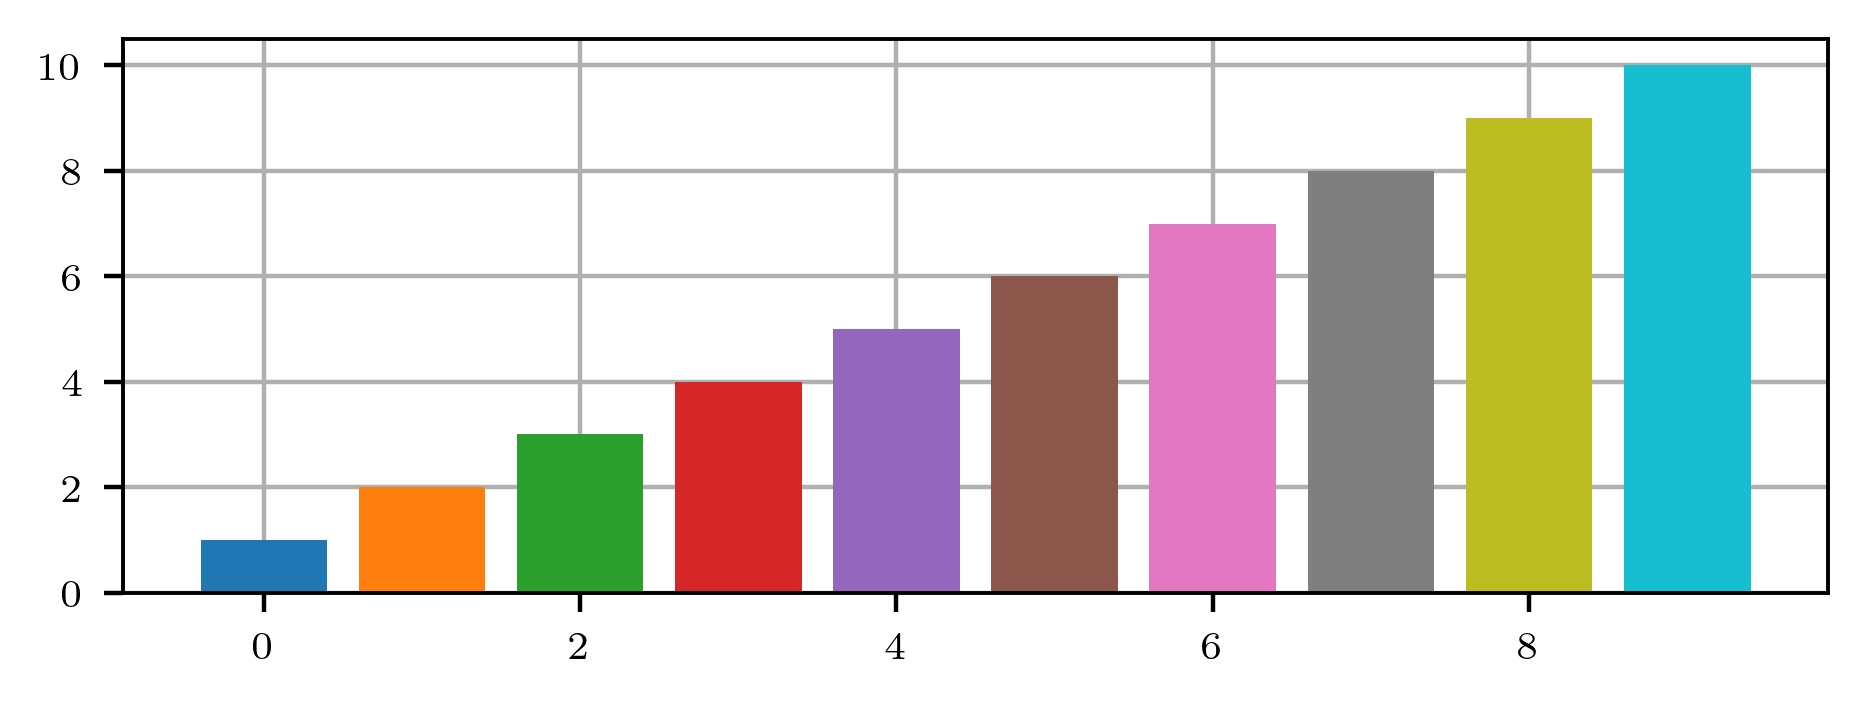

In [32]:
import matplotlib
# matplotlib.use('pgf')

import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
     '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

markerlist = ['o', 4, 5, 6, 7, 'p', 'd', 'P']


text_width = 5.5  # in  --> Confirmed with template explanation

fs_m1 = 7  # for figure ticks
fs = 9  # for regular figure text
fs_p1 = 10  # figure titles

axes_lw = 0.7

matplotlib.rc('font', size=fs)          # controls default text sizes
matplotlib.rc('axes', titlesize=fs)     # fontsize of the axes title
matplotlib.rc('axes', labelsize=fs)    # fontsize of the x and y labels
matplotlib.rc('axes', linewidth=axes_lw)    # fontsize of the x and y labels
matplotlib.rc('xtick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('ytick', labelsize=fs_m1)    # fontsize of the tick labels
matplotlib.rc('legend', fontsize=fs_m1)    # legend fontsize
matplotlib.rc('figure', titlesize=fs_p1)  # fontsize of the figure title


matplotlib.rc('font', **{'family': 'serif', 'serif': ['Times New Roman']})

matplotlib.rc('text', usetex=True)

plt.rcParams.update({'text.latex.preamble': r'\usepackage{amsmath}'})

# Test setup

plt.figure(dpi=400, figsize=(text_width, text_width/3))
plt.grid(0.3, zorder=0)
for i in range(10):
    plt.bar(i, i + 1, color=f'C{i}', zorder=2)
    # ^ This zorder nonsense makes the grid  lines go behid the bars. I don't know why this is needed for barplots, but shouldn't usually be needed.
# plt.title(r'\textbf{Test}, $\mathcal{C}, \mathbb{R}$')
# plt.xlabel('test $x$')
# plt.ylabel('test $y$')
# plt.show()

# Define errorfill


def errorfill(x, y, yerr, color=None, alpha_fill=0.3, line_alpha=1, ax=None,
              lw=1, linestyle='-', fill_linewidths=0.2,
              marker=None, markersize=1, label=None):
    ax = ax if ax is not None else plt.gca()
    if color is None:
        color = ax._get_lines.color_cycle.next()
    if np.isscalar(yerr) or len(yerr) == len(y):
        ymin = y - yerr
        ymax = y + yerr
    elif len(yerr) == 2:
        ymin, ymax = yerr
    plt_return = ax.plot(x, y, color=color, lw=lw, linestyle=linestyle, alpha=line_alpha, label=label, marker=marker, markersize=markersize)
    ax.fill_between(x, ymax, ymin, color=color, alpha=alpha_fill, linewidths=fill_linewidths)
    return plt_return


## package imports

In [3]:

import jax
from jax import jit, vmap
from functools import partial
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scalable_gps
from scalable_gps import data
from scalable_gps.kernels import RBFKernel
from scalable_gps.models.exact_gp_model import ExactGPModel
from scalable_gps.models.sgd_gp_model import SGDGPModel

import ml_collections



## Generate Data

Text(0.5, 1.0, 'concentrating dataset')

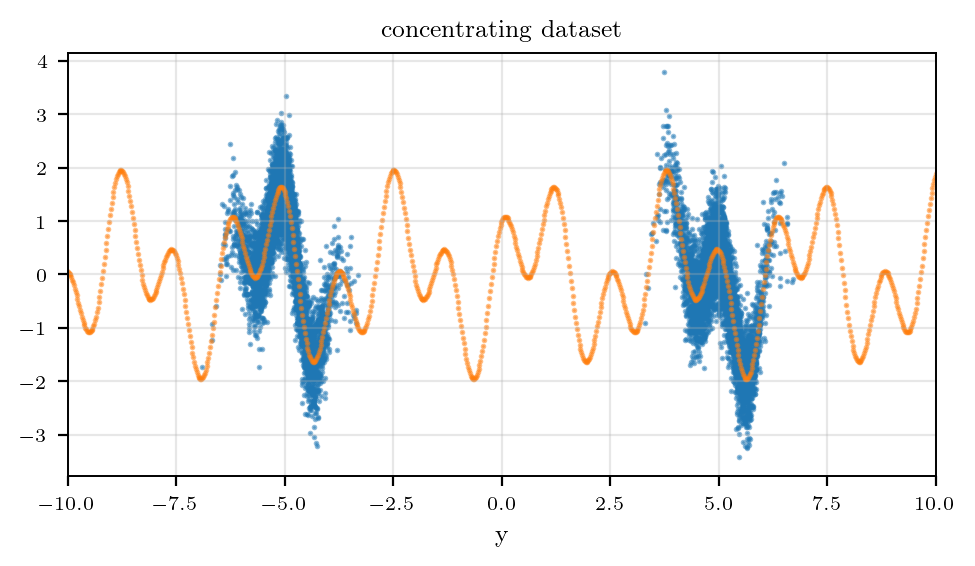

In [4]:
noise_scale = 0.5
n_data = 10000
n_test = 1000
separation = 10
x_std = 0.5
seed = 3

data_train, data_test = data.get_split_toy_sin_dataset(
    seed=seed,
    n=n_data,
    noise_scale=noise_scale,
    n_test=n_test,
    x_std = x_std,
    separation=separation,
    normalise=False
)


fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/2), dpi=200)
ax = [ax]
ax[0].scatter(data_train.x, data_train.y,  1, alpha=0.5, c=c[0])
ax[0].scatter(data_test.x, data_test.y,  1, alpha=0.5, c=c[1])
ax[0].set_xlabel('x')
ax[0].set_xlabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-10,10])
ax[0].set_title('concentrating dataset')



## hyperparams

In [5]:
kernel_config = {
    'signal_scale': jnp.array([2.]),
    'length_scale': jnp.array([0.5]),
}

kernel = RBFKernel(kernel_config=kernel_config)


## ExactGP fits

In [6]:



exact_gp = ExactGPModel(noise_scale=noise_scale, kernel=kernel)
exact_gp.compute_representer_weights(data_train)
exact_pred_mean = exact_gp.predictive_mean(data_train, data_test)
exact_pred_var = exact_gp.predictive_variance(data_train, data_test) + noise_scale ** 2
exact_pred_std = jnp.sqrt(exact_pred_var)
print('exact_pred_mean', exact_pred_mean.shape, 'exact_pred_var', exact_pred_var.shape)



exact_pred_mean (1000,) exact_pred_var (1000,)


### view exact GP fits

Text(0.5, 1.0, 'concentrating dataset exact GP')

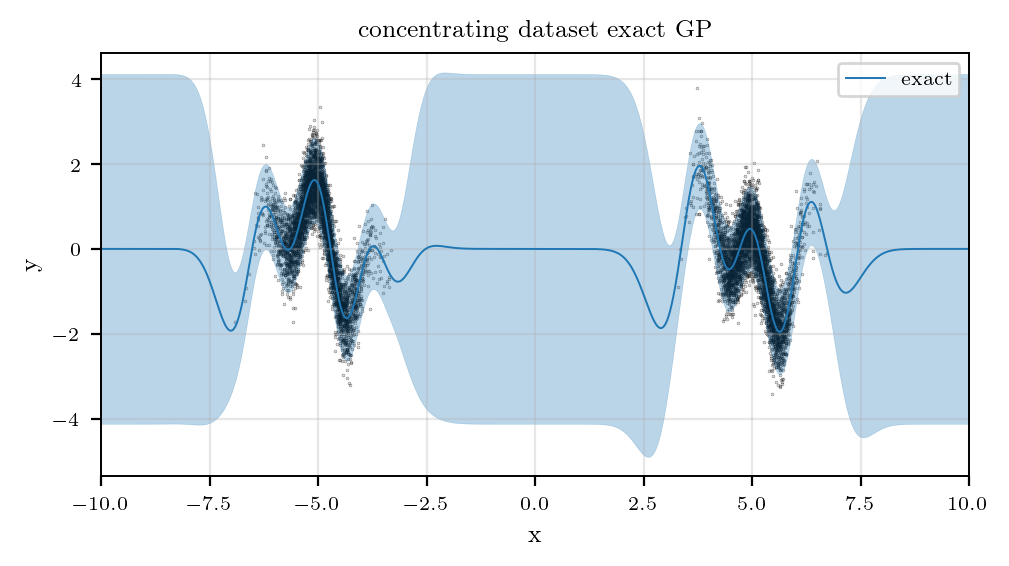

In [7]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/2), dpi=200)
ax = [ax]
ax[0].scatter(data_train.x, data_train.y,  0.05, alpha=0.5, c='k')
# ax[0].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.7, label='true')
errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.7, linestyle='-', fill_linewidths=0.2, marker=None, markersize=1, label='exact')
ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-10,10])
ax[0].legend()
ax[0].set_title('concentrating dataset exact GP')


# Sampling fits

In [8]:
from scalable_gps.utils import ExactPredictionsTuple

exact_metrics = ExactPredictionsTuple(
                alpha=exact_gp.alpha, y_pred_loc=exact_pred_mean)


            

### SGDGP

In [9]:
def info_to_dict(info, average_samples=True):
    keys = info[0].keys()

    training_results = {}

    for key in keys:
        result_vec = []
        for entry in info:
            if average_samples:
                result_vec.append(entry[key].mean(keepdims=True))
            else:
                result_vec.append(entry[key])
        training_results[key[1:]] = jnp.array(result_vec)
    return training_results

def plot_training_results(info):
    training_results = info_to_dict(info)
    num_entries = len(training_results.keys())
    fig, ax = plt.subplots(1,num_entries, dpi=200, figsize=(text_width,text_width/3))
    for i, key in enumerate(training_results.keys()):
        ax[i].plot(training_results[key])
        ax[i].set_yscale('log')
        ax[i].grid(alpha=0.3)
        ax[i].set_title(key)
    plt.tight_layout()
    plt.show()

### config

In [10]:
config = ml_collections.ConfigDict()
config.train_config = ml_collections.ConfigDict()

config.train_config.iterations = 50000
config.train_config.batch_size = 1000
config.train_config.eval_every = 100

# RFF Configs
config.train_config.n_features_optim = 100
config.train_config.recompute_features = True

# Optimisation Configs
config.train_config.iterative_idx = True
config.train_config.learning_rate = 1e-2
config.train_config.momentum = 0.9
config.train_config.nesterov = True
config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

polyak_k = 50
polyak_step = polyak_k / config.train_config.iterations
print('polyak_step', polyak_step)
config.train_config.polyak = polyak_step

config.train_config.absolute_clipping = 0.1  # -1 to avoid clipping

config.train_config.lr_schedule_name = None # "linear_schedule"
config.train_config.lr_schedule_config = ml_collections.ConfigDict()


# sampling 

config.sampling_config = ml_collections.ConfigDict()

config.sampling_config = config.train_config.copy_and_resolve_references()
config.sampling_config.n_samples = 2000
# Full-batch training configs that get passed
config.sampling_config.iterative_idx = True
config.sampling_config.learning_rate = 2e-5
config.sampling_config.momentum = 0.9
config.sampling_config.iterations = 120000
config.sampling_config.batch_size = 500
config.sampling_config.absolute_clipping = 0.1  # -1 to avoid clipping


config.sampling_config.eval_every = 100 # eval every how many number of steps 

polyak_k = 50
polyak_step = polyak_k / config.sampling_config.iterations
print('polyak_step', polyak_step)
config.sampling_config.polyak = polyak_step


metrics_list = ['loss',  "test_rmse", "y_pred_diff", "alpha_rkhs_diff"] # see eval_utils.get_eval_fn

# RFF Configs
config.sampling_config.n_features_prior_sample = 2000
config.sampling_config.n_features_optim = 100
config.sampling_config.recompute_features = True
config.sampling_config.loss_objective = 2
# config.sampling_config.use_cholesky_prior_sample = False


config.train_config.time_budget_in_seconds = -1
config.train_config.eval_every_in_seconds = None

metrics_list = ["loss",  "test_rmse", "y_pred_diff", "alpha_rkhs_diff"] # "err", "reg",


polyak_step 0.001
polyak_step 0.0004166666666666667


In [11]:

optim_key = jax.random.PRNGKey(0)


In [12]:
config.train_config.preempt_safe=False
config.sampling_config.preempt_safe=False
sgd_gp = SGDGPModel(noise_scale=noise_scale, kernel=kernel)

#### concetrate

All save steps: [Array(5000, dtype=int32), Array(10000, dtype=int32), Array(15000, dtype=int32), Array(20000, dtype=int32), Array(25000, dtype=int32), Array(30000, dtype=int32), Array(35000, dtype=int32), Array(40000, dtype=int32), Array(45000, dtype=int32)]


100%|███████████████████████████████████| 50000/50000 [00:40<00:00, 1240.16it/s]


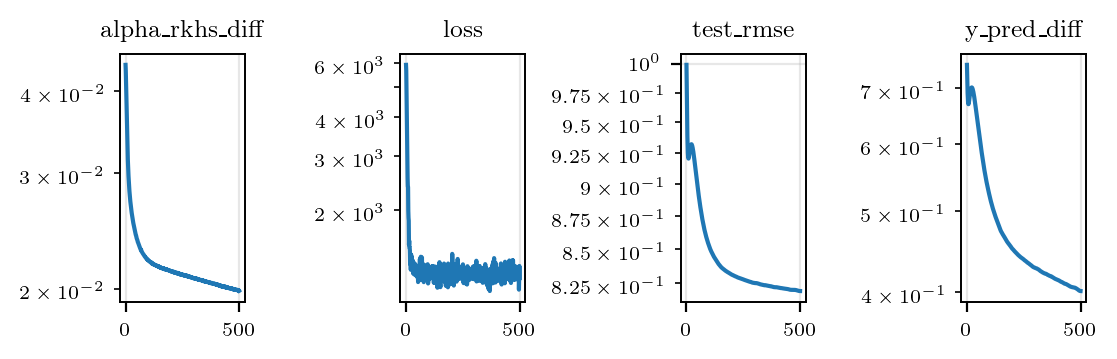

In [14]:


# MAP
alpha_polyak, info = sgd_gp.compute_representer_weights(
    key=optim_key,
    train_ds=data_train, 
    test_ds=data_test,
    config=config.train_config,
    metrics_list=metrics_list,
    exact_metrics=exact_metrics  # exact_metrics
)

sgd_pred_mean = sgd_gp.predictive_mean(data_train, data_test)
plot_training_results(info)

# sampling



In [13]:
zero_mean_samples, alpha_samples, w_samples = sgd_gp.compute_posterior_samples(
                                        optim_key, 
                                        n_samples=config.sampling_config.n_samples,
                                        train_ds=data_train,
                                        test_ds=data_test,
                                        config=config.sampling_config,
                                        use_rff=True,
                                        n_features=config.sampling_config.n_features_prior_sample,
                                        metrics_list = metrics_list,
                                        compare_exact=True,  # allows diff metrics with exact GP
                                    )
sgd_pred_var_samples = sgd_gp.predictive_variance_samples(zero_mean_samples) + noise_scale ** 2
sgd_pred_std_samples = jnp.sqrt(sgd_pred_var_samples)

print(f'zero_mean_samples : {zero_mean_samples.shape}')
print(f'alpha_samples : {alpha_samples.shape}')

# plot_training_results(info)



gpu:0 gpu:0


  0%|                                                | 0/120000 [00:00<?, ?it/s]

alpha_exact.shape: (10000,)


100%|███████████████████████████████████| 120000/120000 [20:55<00:00, 95.61it/s]


zero_mean_samples : (1, 2000, 1000)
alpha_samples : (1, 2000, 10000)


In [15]:
sgd_pred_var_samples = sgd_gp.predictive_variance_samples(zero_mean_samples[0]) + noise_scale ** 2
sgd_pred_std_samples = jnp.sqrt(sgd_pred_var_samples)


#### basic plot

Text(0.5, 1.0, 'concentrating dataset')

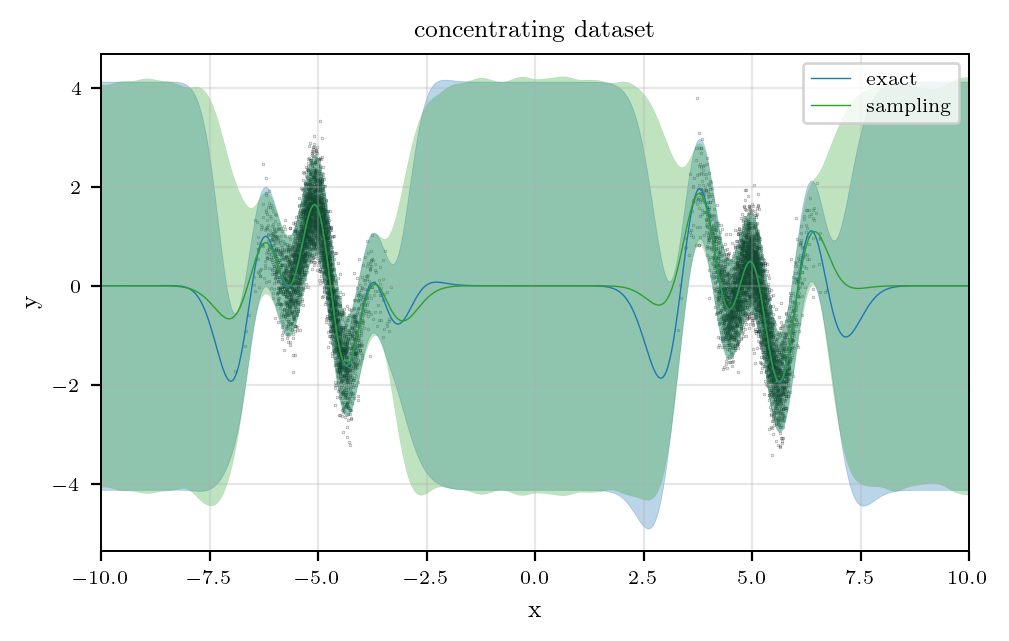

In [22]:
fig, ax = plt.subplots(1,1, figsize=(text_width,text_width/1.7), dpi=200)

ax = [ax]

ax[0].scatter(data_train.x, data_train.y,  0.03, alpha=0.5, c='k')
# ax[0].plot(data_test.x, data_test.y, alpha=1., c='k', linewidth=0.5, label='true')

errorfill(data_test.x.squeeze(), exact_pred_mean, 2*exact_pred_std,
          color=c[0], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.3, marker=None, markersize=1, label='exact')


errorfill(data_test.x.squeeze(), sgd_pred_mean, 2*sgd_pred_std_samples,
          color=c[2], alpha_fill=0.3, line_alpha=1, ax=ax[0],
              lw=0.5, linestyle='-', fill_linewidths=0.1, marker=None, markersize=1, label='sampling')


ax[0].set_xlabel('x')
ax[0].set_ylabel('y')
ax[0].grid(alpha=0.3)
ax[0].set_xlim([-10,10])
ax[0].legend()
ax[0].set_title('concentrating dataset')



## save sampling alphas (TODO: adapt) 

In [17]:
# import pickle
# filename = b"./save_data/sampling_outputs.obj"

# # save_list = [concentrate_zero_mean_samples, concentrate_alpha_samples,
# #              spread_zero_mean_samples, spread_alpha_samples]

# # filehandler = open(filename,"wb")
# # pickle.dump(save_list,filehandler)
# # filehandler.close()

# file = open(filename,'rb')
# (concentrate_zero_mean_samples, concentrate_alpha_samples,
#              _, _) = pickle.load(file) # spread_zero_mean_samples, spread_alpha_samples
# file.close()

# concentrate_sgd_pred_var_samples = concentrate_sgd_gp.predictive_variance_samples(concentrate_zero_mean_samples) + noise_scale ** 2
# concentrate_sgd_pred_std_samples = jnp.sqrt(concentrate_sgd_pred_var_samples)

# print(f'zero_mean_samples : {concentrate_zero_mean_samples.shape}')
# print(f'alpha_samples : {concentrate_alpha_samples.shape}')

# spread_sgd_pred_var_samples = spread_sgd_gp.predictive_variance_samples(spread_zero_mean_samples) + noise_scale ** 2
# spread_sgd_pred_std_samples = jnp.sqrt(spread_sgd_pred_var_samples)

# print(f'zero_mean_samples : {spread_zero_mean_samples.shape}')
# print(f'alpha_samples : {spread_alpha_samples.shape}')


# Paper SGD function error / eigenfunction plot

### compute eigenfunctions (page 99 GPML book: https://gaussianprocess.org/gpml/chapters/RW.pdf)

TODO: move to utils

In [23]:
from scalable_gps.linalg_utils import KvP
import chex 

In [24]:

def gen_eigenfun_fun(x_train, eval_points, exact_gp):
    chex.assert_equal_shape_suffix([x_train, eval_points], suffix_len=1) 
    sym_k = (exact_gp.K + exact_gp.K.T) / 2
    dim = exact_gp.K.shape[0]
    eig_vals, eig_vecs = jnp.linalg.eigh(sym_k)
    eigenfuncs_at_train = jnp.sqrt(dim) * eig_vecs / eig_vals[None, :]
    @jax.jit
    def get_eigenfunction(index):
        ref = eigenfuncs_at_train[:, (dim - 1 - index)]
        return KvP(eval_points, x_train, ref, kernel_fn=exact_gp.kernel.kernel_fn)
    return get_eigenfunction, eig_vals


eval_points = jnp.linspace(-10, 10, 1000)[:,None]
get_eigenfunction, eigenvals = gen_eigenfun_fun(data_train.x, eval_points, exact_gp)

eig_vals_sorted = eigenvals[::-1]
eig_vals_sorted = eig_vals_sorted[eig_vals_sorted>0]
    

## show error dependence on eigenfunctions

## TODO: make exact GP dashed black -- keep true function

In [25]:
W2 = (exact_pred_mean - sgd_pred_mean)**2 + (exact_pred_std - sgd_pred_std_samples)**2


In [30]:
text_width

5.60107

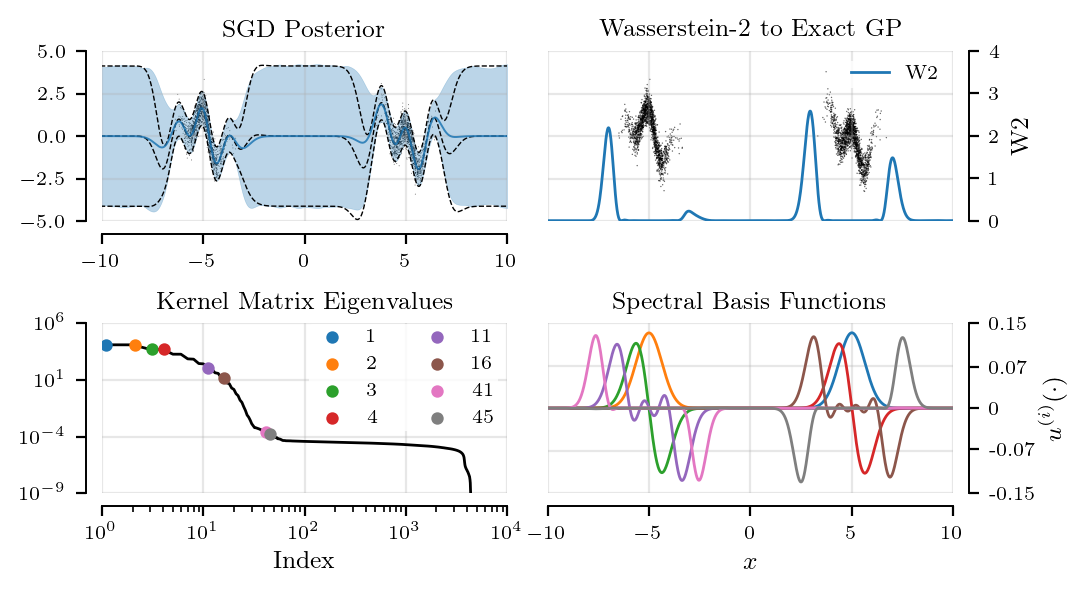

In [36]:
fig, ax = plt.subplots(2,2, figsize=(text_width,text_width/1.8), dpi=200) #sharex='col'


titlepad = 5.
xpad=3.3
ypad=1.

# samples

top_subsample_rate = 4
top_point_size = 0.13
top_point_alpha = 0.6

w2_subsample_rate = 3
w2_point_size = 0.25
w2_point_alpha = 0.6

# exact GP
exact_errorbar_lw = 0.5
exact_mean_lw = 0.5
exact_alpha = 1

# methods
method_lw = 0.7
fill_alpha = 0.3
fill_linewidths = 0.2
line_alpha = 0.85

#############



ax[0,0].scatter(data_train.x[::top_subsample_rate],
                data_train.y[::top_subsample_rate],  top_point_size,
                alpha=top_point_alpha, c='k', linewidths=None, edgecolors='none')

ax[0,0].plot(data_test.x, exact_pred_mean,
             alpha=exact_alpha, c='k', linewidth=exact_mean_lw, label='exact GP', linestyle='--')
ax[0,0].plot(data_test.x, exact_pred_mean+2*exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')
ax[0,0].plot(data_test.x, exact_pred_mean-2*exact_pred_std,
             alpha=exact_alpha, c='k', linewidth=exact_errorbar_lw, label=None, linestyle='--')




errorfill(data_test.x.squeeze(), sgd_pred_mean, 2*sgd_pred_std_samples,
          color=c[0], alpha_fill=fill_alpha, line_alpha=line_alpha, ax=ax[0,0],
              lw=method_lw, linestyle='-', fill_linewidths=fill_linewidths, marker=None,
          markersize=1)



# SHOW W2 error




ax[0,1].scatter(data_train.x[::w2_subsample_rate],
                data_train.y[::w2_subsample_rate],  w2_point_size,
                alpha=w2_point_alpha, c='k', linewidths=None, edgecolors='none')
# ax01_twinx.set_yticks([])

ax01_twinx = ax[0,1].twinx()
ax01_twinx.plot(data_test.x.squeeze(), W2, linewidth=1, label='W2')



# SHOW eigenfunctions

ax11_twinx = ax[1,1].twinx()

indices = [0, 1, 2,3,10, 15, 40,44] # #  2,3
for iii, idx in enumerate(indices):
    norm_fn = get_eigenfunction(idx) / jnp.linalg.norm(get_eigenfunction(idx))
    ax11_twinx.plot(eval_points, norm_fn, c=c[iii], label=f'{idx+1}', linewidth=1)


# Eigenvalues

ax[1,0].plot(jnp.arange(1, len(eig_vals_sorted)+1), eig_vals_sorted, c='k', linewidth=1)
for iii, idx in enumerate(indices):
    ax[1,0].scatter(idx+1+0.1, eig_vals_sorted[idx], 12, c=c[iii], label=f'{idx+1}', zorder=10)


    
### Plot elements ####


for aa in ax.ravel():
    aa.grid(alpha=0.3)

ax[0,0].set_xlim([-10,10])
ax[0,1].set_xlim([-10,10])
ax11_twinx.set_xlim([-10,10])


ax[0,0].set_ylim([-5,5])
ax[0,1].set_ylim([-5,5])
ax[0,0].set_yticks([-5, -2.5,0,2.5,5])
ax[0,1].set_yticks([-5, -2.5,0,2.5,5])


ax11_twinx.set_ylim([-0.15,0.15])
ax11_twinx.set_yticks([-0.15, -0.0725, 0, 0.0725, 0.15])
ax11_twinx.set_yticklabels([-0.15, -0.07, 0, 0.07, 0.15])
ax11_twinx.set_ylabel('$u^{(i)}(\cdot)$', labelpad=ypad)


ax[1,0].set_xlim([1, 1e4])




ax[0,0].set_title('SGD Posterior', pad=titlepad)
ax[0,1].set_title('Wasserstein-2 to Exact GP', pad=titlepad)
ax[1,1].set_title('Spectral Basis Functions', pad=titlepad)
ax[1,0].set_title('Kernel Matrix Eigenvalues', pad=titlepad)

# TOP row y fit ticks -- left


# legend = ax[0,0].legend(loc='lower center', bbox_to_anchor=(0.5,-0.02), frameon=True, borderpad=0.25)
# legend.get_frame().set_linewidth(0.)


# top row right hand W2
ax01_twinx.set_ylabel('W2')
ax01_twinx.set_ylim([-0.01, 4])
ax01_twinx.set_yticks([0, 1,2,3, 4])
legend = ax01_twinx.legend( borderpad=0.25)
legend.get_frame().set_linewidth(0.)

# Eigenvalues / eigenfunctions


ax[1,0].set_yscale('log')
ax[1,0].set_xscale('log')

ax[1,0].set_xlabel('Index', labelpad=xpad)
# ax[1,0].set_ylabel('power')
legend=ax[1,0].legend(frameon=True, ncol=2, borderpad=0.2, loc='upper right', bbox_to_anchor=(1,1.05))
legend.get_frame().set_linewidth(0.)

ax[1,1].set_xlabel(r'$x$', labelpad=xpad)



# ax[0,0].set_xlabel('x')
# ax[0,0].set_ylabel('y')




## DESPINE

def remove_xticks(aax):
    for tick in aax.xaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    aax.set_xticklabels([])
        
def remove_yticks(aax):
    for tick in aax.yaxis.get_major_ticks():
        tick.tick1line.set_visible(False)
        tick.tick2line.set_visible(False)
    aax.set_yticklabels([])

#  # apply to all
for aax in ax.ravel():
    aax.spines[['right', 'top']].set_visible(False)
    aax.spines['bottom'].set_position(('axes', -0.075))
    aax.spines['left'].set_position(('axes', -0.04))
    
ax[0,1].spines[['left', 'bottom']].set_visible(False)
ax01_twinx.spines[['left', 'top', 'bottom']].set_visible(False)

ax01_twinx.spines['right'].set_position(('axes', 1.04))

remove_xticks(ax[0,1])
remove_yticks(ax[0,1])

ax[1,1].spines[['left']].set_visible(False)
ax11_twinx.spines[['left', 'top', 'bottom']].set_visible(False)
ax11_twinx.spines['right'].set_position(('axes', 1.04))    

remove_yticks(ax[1,1])


ax[1,0].set_ylim([1e-9, 1e6])
ax[1,0].set_yticks([1e-9, 1e-4, 1e1, 1e6])

plt.tight_layout()



plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.1, hspace=0.6)



# plt.savefig('./plots' + f'/eigenfunctions_and_error.pdf', dpi=350, format="pdf", bbox_inches='tight', pad_inches=0.01)

